>## Global Market forecasting with Facebook Prophet

---
### *Cleaning & Preparing Data*

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['xtick.labelsize'] = 10
matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['text.color'] = 'k'
df = pd.read_excel("Dataset11.xlsx")
online = df.loc[df['SALES_CHANNEL'] == 'Online']
offline = df.loc[df['SALES_CHANNEL'] == 'Offline']

In [2]:
online.shape, offline.shape

((979, 13), (1025, 13))

In [4]:
cols = ['REGION','SALES_CHANNEL','UNITS_SOLD','COUNTRY','ITEM_TYPE','QUALITY_PRODUCT','ORDER_DATE','ORDER_ID','UNIT_PRICE','UNIT_COST','TOTAL_COST']
online.drop(cols, axis=1, inplace=True)
offline.drop(cols, axis=1, inplace=True)

online = online.sort_values('SHIP_DATE')
offline = offline.sort_values('SHIP_DATE')

online = online.groupby('SHIP_DATE')['TOTAL_PROFIT'].sum().reset_index()
offline = offline.groupby('SHIP_DATE')['TOTAL_PROFIT'].sum().reset_index()

---
### *Data exploration*

In [5]:
online = online.set_index('SHIP_DATE')
offline = offline.set_index('SHIP_DATE')

y_online = online['TOTAL_PROFIT'].resample('MS').mean()
y_offline = offline['TOTAL_PROFIT'].resample('MS').mean()

online = pd.DataFrame({'SHIP_DATE':y_online.index, 'TOTAL_PROFIT':y_online.values})
offline = pd.DataFrame({'SHIP_DATE': y_offline.index, 'TOTAL_PROFIT': y_offline.values})

store = online.merge(offline, how='inner', on='SHIP_DATE')
store.rename(columns={'TOTAL_PROFIT_x': 'online_TP', 'TOTAL_PROFIT_y': 'offline_TP'}, inplace=True)
store.head()

,SHIP_DATE,online_TP,offline_TP
0,2010-01-01,151361.340000,589951.338333
1,2010-02-01,732704.212500,568745.743333
2,2010-03-01,541667.808462,496859.488000
3,2010-04-01,440911.431000,610470.077500
4,2010-05-01,508304.620000,485720.598571


### *Plotting graph of historical data*

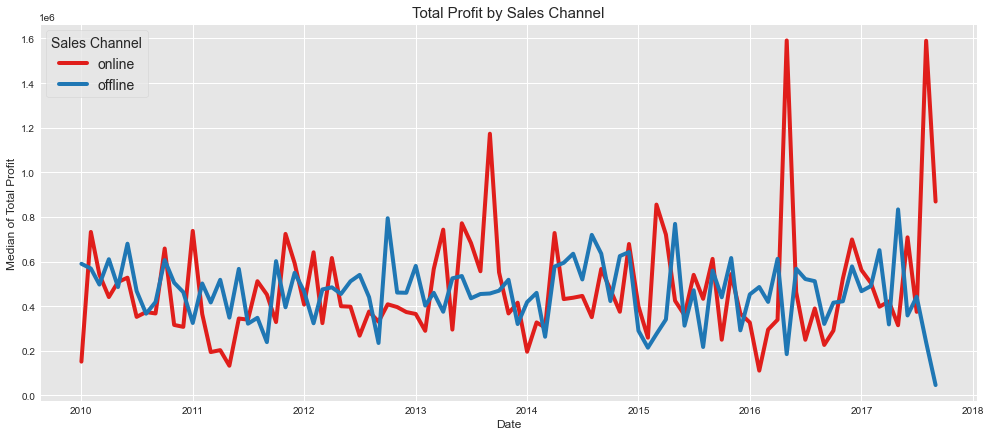

In [19]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='Set1')
sns_c = sns.color_palette(palette='Set1')

fig, ax = plt.subplots(figsize=(15, 6.5))

ax = sns.lineplot(x=store['SHIP_DATE'], y=store['online_TP'], color='#E01E1B', label='online');
ax = sns.lineplot(x=store['SHIP_DATE'], y=store['offline_TP'], color='#1f77b4', label='offline');

ax.legend(loc='upper left',title = 'Sales Channel')
ax.set_title('Total Profit by Sales Channel', fontsize = 15)
ax.set(ylabel='Median of Total Profit',xlabel='Date')
plt.savefig('2.svg');

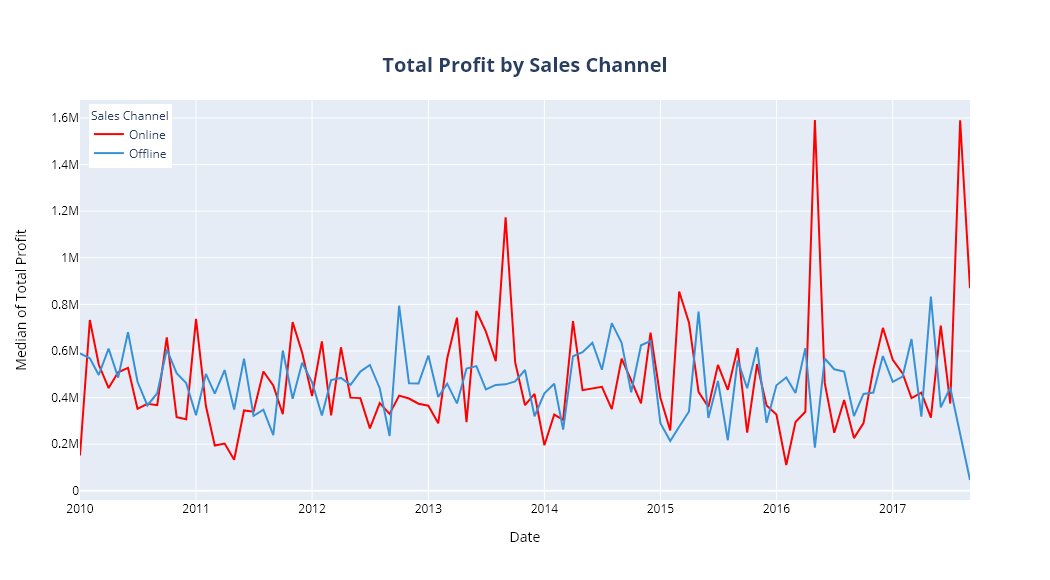

In [20]:
import plotly.graph_objects as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=store['SHIP_DATE'], 
    y=store['online_TP'],
    line=dict(color='red'),
#     stackgroup='one',
    mode='lines',
    name='Online'
))

fig.add_trace(go.Scatter(
    x=store['SHIP_DATE'], 
    y=store['offline_TP'],
    line=dict(color='#3791D7'),
#     stackgroup='one',
    mode='lines',
    name='Offline'
))

fig.update_layout(
    legend_title_text='Sales Channel',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
),
    yaxis=dict(title="Median of Total Profit",color='black'),
    xaxis=dict(title="Date",color='black'),
    title={
        'font_size':20,
        'text': "<b>Total Profit by Sales Channel<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
img_bytes = fig.to_image(format="png", width=1050, height=580, validate=True)
Image(img_bytes)

---
### *Prophet Forecasting Model*
Released by Facebook in 2017, forecasting tool Prophet is designed for analyzing time-series that display patterns on different time scales such as yearly, weekly and daily. It also has advanced capabilities for modeling the effects of holidays on a time-series and implementing custom changepoints. Therefore, we are using Prophet to get a model up and running.

### *Equation of the model is -*

<p align="center">
  <img src="https://miro.medium.com/max/659/1*Oe2mGHiiwDMmRcBlbvS39Q.png?raw=true" alt="Sublime's custom image"/>
</p>

**where:**
- $g(t)$ : the trend function which models non-periodic changes using either a non linear saturation growth model or piecewise linear regression model.

- $s(t)$ : the seasonal functional (yearly, weekly and daily) which models the periodic changes in the value of the time series. This component is modelled using a Fourier transform and if you want you can add your own seasonalities.

- $h(t)$ : represents the function for modelling holidays and special impact events. You can add your own set of custom holidays and special events.

- $ε(t)$ : the models error/noise which is assumed being normal distributed

**In other words, the procedure’s equation can be written**

<p align="center">
  <img src="https://miro.medium.com/max/399/1*ou96ceGd-wtOMFXSUl0Dtw.png?raw=true" alt="Sublime's custom image"/>
</p>

In [6]:
from fbprophet import Prophet
import logging

# disable informational messages from fbprophet
logging.getLogger('py4j').setLevel(logging.ERROR)

In [34]:
online = online.rename(columns={'SHIP_DATE': 'ds', 'TOTAL_PROFIT': 'y'})
online_model = Prophet(changepoint_prior_scale=0.01, interval_width=0.95, daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True, seasonality_mode='multiplicative')
online_model.fit(online)

offline = offline.rename(columns={'SHIP_DATE': 'ds', 'TOTAL_PROFIT': 'y'})
offline_model = Prophet(changepoint_prior_scale=0.01, interval_width=0.95, daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=True, seasonality_mode='multiplicative')
offline_model.fit(offline)

In [45]:
online_forecast = online_model.make_future_dataframe(periods=12*5, freq='MS',include_history=True)
online_forecast = online_model.predict(online_forecast)

offline_forecast = offline_model.make_future_dataframe(periods=12*5, freq='MS',include_history=True)
offline_forecast = offline_model.predict(offline_forecast)

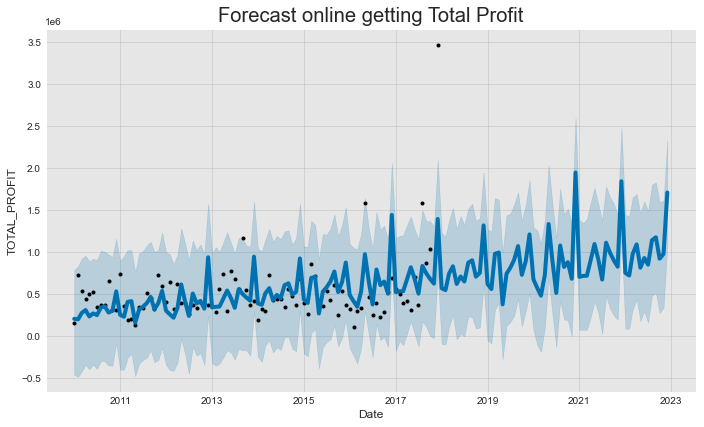

In [46]:
online_model.plot(online_forecast, xlabel = 'Date', ylabel = 'TOTAL_PROFIT')
plt.title('Forecast online getting Total Profit');

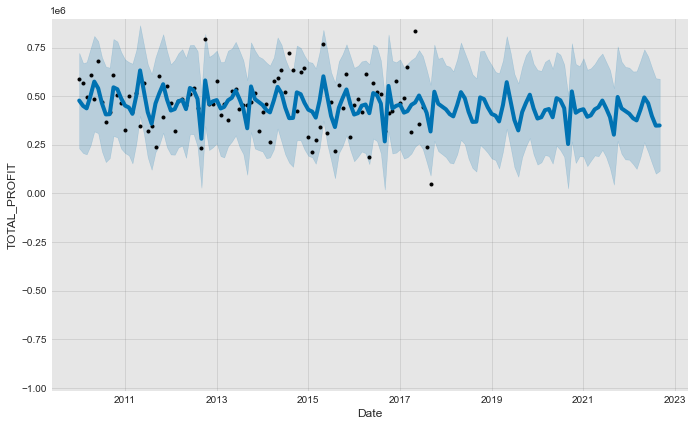

In [37]:
predict_fig = offline_model.plot(offline_forecast, xlabel = 'Date', ylabel = 'TOTAL_PROFIT')

# adjust figure to display dates from last year + the 90 day forecast
ylim = predict_fig.axes[0].get_ylim()
new_ylim = ( ylim[0]-(1000000))
predict_fig.axes[0].set_ylim(new_ylim);

---
### *Compare Forecasts*

In [38]:
online_names = ['online_%s' % column for column in online_forecast.columns]
offline_names = ['offline_%s' % column for column in offline_forecast.columns]

merge_online_forecast = online_forecast.copy()
merge_offline_forecast = offline_forecast.copy()

merge_online_forecast.columns = online_names
merge_offline_forecast.columns = offline_names

forecast = pd.merge(merge_online_forecast, merge_offline_forecast, how = 'inner', left_on = 'online_ds', right_on = 'offline_ds')

forecast = forecast.rename(columns={'online_ds': 'Date'}).drop('offline_ds', axis=1)
forecast.head()

,Date,online_trend,online_yhat_lower,online_yhat_upper,online_trend_lower,online_trend_upper,online_multiplicative_terms,online_multiplicative_terms_lower,online_multiplicative_terms_upper,online_yearly,...,offline_multiplicative_terms,offline_multiplicative_terms_lower,offline_multiplicative_terms_upper,offline_yearly,offline_yearly_lower,offline_yearly_upper,offline_additive_terms,offline_additive_terms_lower,offline_additive_terms_upper,offline_yhat
0,2010-01-01,267455.283329,-467851.693270,868315.244764,267455.283329,267455.283329,-0.227980,-0.227980,-0.227980,-0.227980,...,-0.038538,-0.038538,-0.038538,-0.038538,-0.038538,-0.038538,0.0,0.0,0.0,477376.102551
1,2010-02-01,272476.515530,-466035.964868,872490.543554,272476.515530,272476.515530,-0.264334,-0.264334,-0.264334,-0.264334,...,-0.093101,-0.093101,-0.093101,-0.093101,-0.093101,-0.093101,0.0,0.0,0.0,449835.764662
2,2010-03-01,277011.822033,-335986.109985,968957.217578,277011.822033,277011.822033,-0.005746,-0.005746,-0.005746,-0.005746,...,-0.117739,-0.117739,-0.117739,-0.117739,-0.117739,-0.117739,0.0,0.0,0.0,437220.441763
3,2010-04-01,282033.054234,-354017.483180,992894.528231,282033.054234,282033.054234,0.103112,0.103112,0.103112,0.103112,...,0.013805,0.013805,0.013805,0.013805,0.013805,0.013805,0.0,0.0,0.0,501906.952492
4,2010-05-01,286892.311200,-404630.266512,822281.860638,286892.311200,286892.311200,-0.181776,-0.181776,-0.181776,-0.181776,...,0.162465,0.162465,0.162465,0.162465,0.162465,0.162465,0.0,0.0,0.0,574947.035013


---
### *Visualizing the Totil Profit forecast*

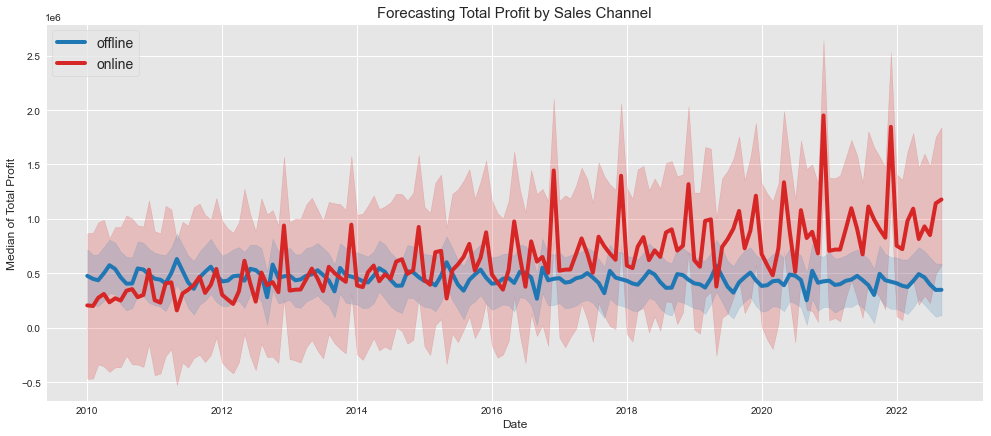

In [39]:
import seaborn as sns
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='Set1')
sns_c = sns.color_palette(palette='Set1')

fig, ax = plt.subplots(figsize=(15, 6.5))
sns.lineplot(x='Date', y='offline_yhat', color='#1f77b4', data=forecast, label='offline', ax=ax)

ax.fill_between(
    x=forecast['Date'],
    y1=forecast['online_yhat_lower'],
    y2=forecast['online_yhat_upper'],
    color=sns_c[0], 
    alpha=0.2
)
#D72626","#3791D7
sns.lineplot(x='Date', y='online_yhat', color='#D72626', data=forecast, label='online', ax=ax)
ax.fill_between(
    x=forecast['Date'],
    y1=forecast['offline_yhat_lower'],
    y2=forecast['offline_yhat_upper'],
    color=sns_c[1], 
    alpha=0.2
)
ax.legend(loc='upper left')
ax.set_title('Forecasting Total Profit by Sales Channel', fontsize = 15)
ax.set(ylabel='Median of Total Profit',xlabel='Date');
plt.savefig('1.svg')

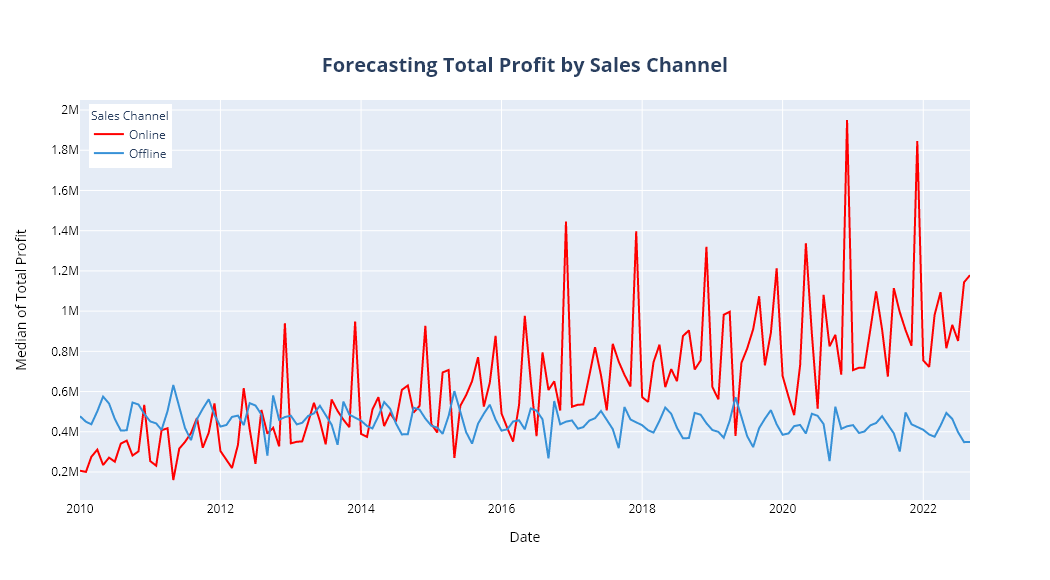

In [40]:
import plotly.graph_objects as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=forecast.Date,
    y=forecast.online_yhat,
    line=dict(color='red'),
#     stackgroup='one',
    mode='lines',
    name='Online'
))

fig.add_trace(go.Scatter(
    x=forecast.Date,
    y=forecast.offline_yhat,
    line=dict(color='#3791D7'),
#     stackgroup='one',
    mode='lines',
    name='Offline'
))

fig.update_layout(
    legend_title_text='Sales Channel',
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
),
    yaxis=dict(title="Median of Total Profit",color='black'),
    xaxis=dict(title="Date",color='black'),
    title={
        'font_size':20,
        'text': "<b>Forecasting Total Profit by Sales Channel<b>",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
img_bytes = fig.to_image(format="png", width=1050, height=580, validate=True)
Image(img_bytes)